In [70]:
import numpy
import pandas as pd
import nltk
import re

In [71]:
titles = open('locations.txt').read().split('\n')
contents = open('trump_speeches.txt').read().split('\n')
print(str(len(titles)) + ' titles')
print(str(len(contents)) + ' contents')
print(titles[:3])
print(contents[2])

60 titles
60 contents
['Remarks Announcing Candidacy for President in New York City ', 'Remarks at the AIPAC Policy Conference in Washington, DC', 'Remarks on Foreign Policy at the National Press Club in Washington, DC']
I would like to talk today about how to develop a new foreign policy direction for our country - one that replaces randomness with purpose, ideology with strategy, and chaos with peace. It is time to shake the rust off of America's foreign policy. It's time to invite new voices and new visions into the fold. The direction I will outline today will also return us to a timeless principle. My foreign policy will always put the interests of the American people, and American security, above all else. That will be the foundation of every decision that I will make. America First will be the major and overriding theme of my administration. But to chart our path forward, we must first briefly look back. We have a lot to be proud of. In the 1940s we saved the world. The Greatest

In [72]:
# generates index for each item in the corpora (in this case it's just rank) and this scoring will be used later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

In [73]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['go', 'think', 'real', 'get', 'gon']

In [74]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [75]:
# here a tokenizer and stemmer are defined which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [76]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in contents:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [77]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.1, stop_words= stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(contents)

print(tfidf_matrix.shape)

CPU times: user 5.68 s, sys: 67.5 ms, total: 5.75 s
Wall time: 5.84 s
(60, 3538)


In [79]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)

["'d", "'d like", "'d say", "'m ask", "'m elect", "'m elect presid", "'m fight", "'m fight everi", "'m make", "'m presid", "'m repeal", "'m repeal replac", "'m run", "'m say", "'m stop", "'m talk", "'m tell", "'s 's", "'s 's happen", "'s also", "'s alway", "'s amaz", "'s america", "'s america first", "'s bad", "'s becaus", "'s begin", "'s call", "'s campaign", "'s corrupt", "'s disast", "'s done", "'s donor", "'s entranc", "'s entranc world", "'s entri", "'s entri world", "'s ever", "'s fail", "'s foreign", "'s foreign polici", "'s gon", "'s gon na", "'s good", "'s got", "'s great", "'s happen", "'s happen 's", "'s hard", "'s interest", "'s largest", "'s like", "'s look", "'s lot", "'s made", "'s made thing", "'s make", "'s messag", "'s nafta", "'s never", "'s one", "'s onli", "'s plan", "'s polici", "'s power", "'s realli", "'s reason", "'s rig", "'s right", "'s say", "'s someth", "'s state", "'s state depart", "'s talk", "'s terribl", "'s time", "'s tough", "'s true", "'s veri", "'s 

In [80]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [81]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 596 ms, sys: 5.78 ms, total: 602 ms
Wall time: 611 ms


In [82]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [83]:
speeches = { 'titles': titles, 'rank': ranks, 'contents': contents, 'cluster': clusters}

frame = pd.DataFrame(speeches, index = [clusters] , columns = ['rank', 'titles', 'cluster'])

In [84]:
frame['cluster'].value_counts() #number of speeches per cluster (clusters from 0 to 4)

3    15
1    13
2    11
0    11
4    10
Name: cluster, dtype: int64

In [85]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    46.272727
1    32.538462
2    30.545455
3    18.933333
4    21.800000
Name: rank, dtype: float64

In [86]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for titles in frame.loc[i]['titles'].values.tolist():
        print(' %s,' % titles, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: illegal, 'm, trump, hillary, criminals, fights,

Cluster 0 titles: Remarks at Prescott Valley Event Center in Prescott Valley, Arizona, Remarks at the Reno-Sparks Convention Center in Reno, Nevada, Excerpts of Remarks at Aaron Bessant Park in Panama City, Florida, Remarks at Toyota of Portsmouth in Portsmouth, New Hampshire, Remarks at the KI Convention Center in Green Bay, Wisconsin, Remarks at the Norris-Penrose Event Center in Colorado Springs, Colorado, Remarks at the Delaware County Fairgrounds in Delaware, Ohio, Remarks at the Newtown Athletic Club Sports Training Center in Newtown, Pennsylvania, Remarks at the Collier County Fairgrounds in Naples, Florida, Remarks at the Phoenix Convention Center in Phoenix, Arizona, Remarks at Macomb Community College South Campus in Warren, Michigan,

Cluster 1 words: na, gon, gon, really, folks, lots,

Cluster 1 titles: Remarks Announcing Candidacy for President in New York City , Remarks Introducing G

In [87]:
#This is purely to help export tables to html and to correct for my 0 start rank 
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['titles']

In [88]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [89]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [90]:
#set up colors per clusters using a dict
cluster_colors = {0: '#7570b3', 1: '#d95f02', 2: '#1b9e77', 3: '#1E90FF', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Fighting with illegal/criminal activities', 
                 1: 'Informal talks', 
                 2: 'Economics and social philanthropy', 
                 3: 'Natonal Safety and defense', 
                 4: 'Inner reforms and parties'}


In [91]:
%matplotlib inline

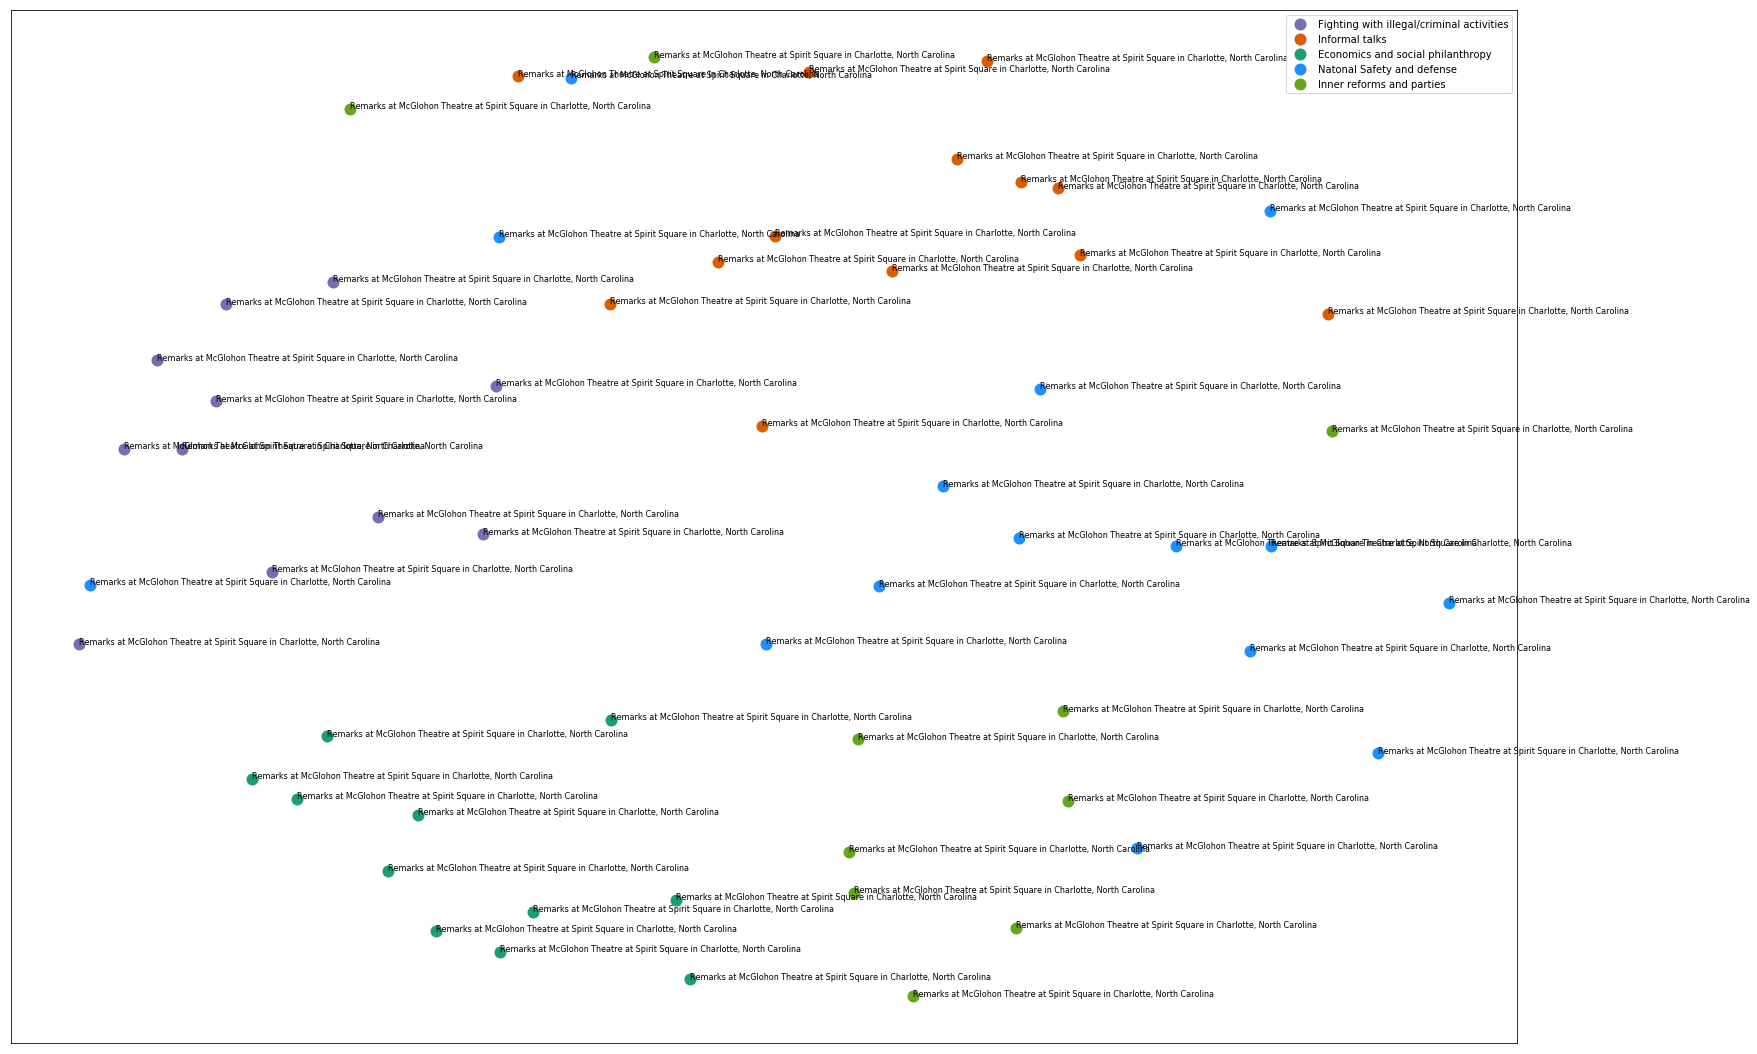

In [93]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title = titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(27, 19)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

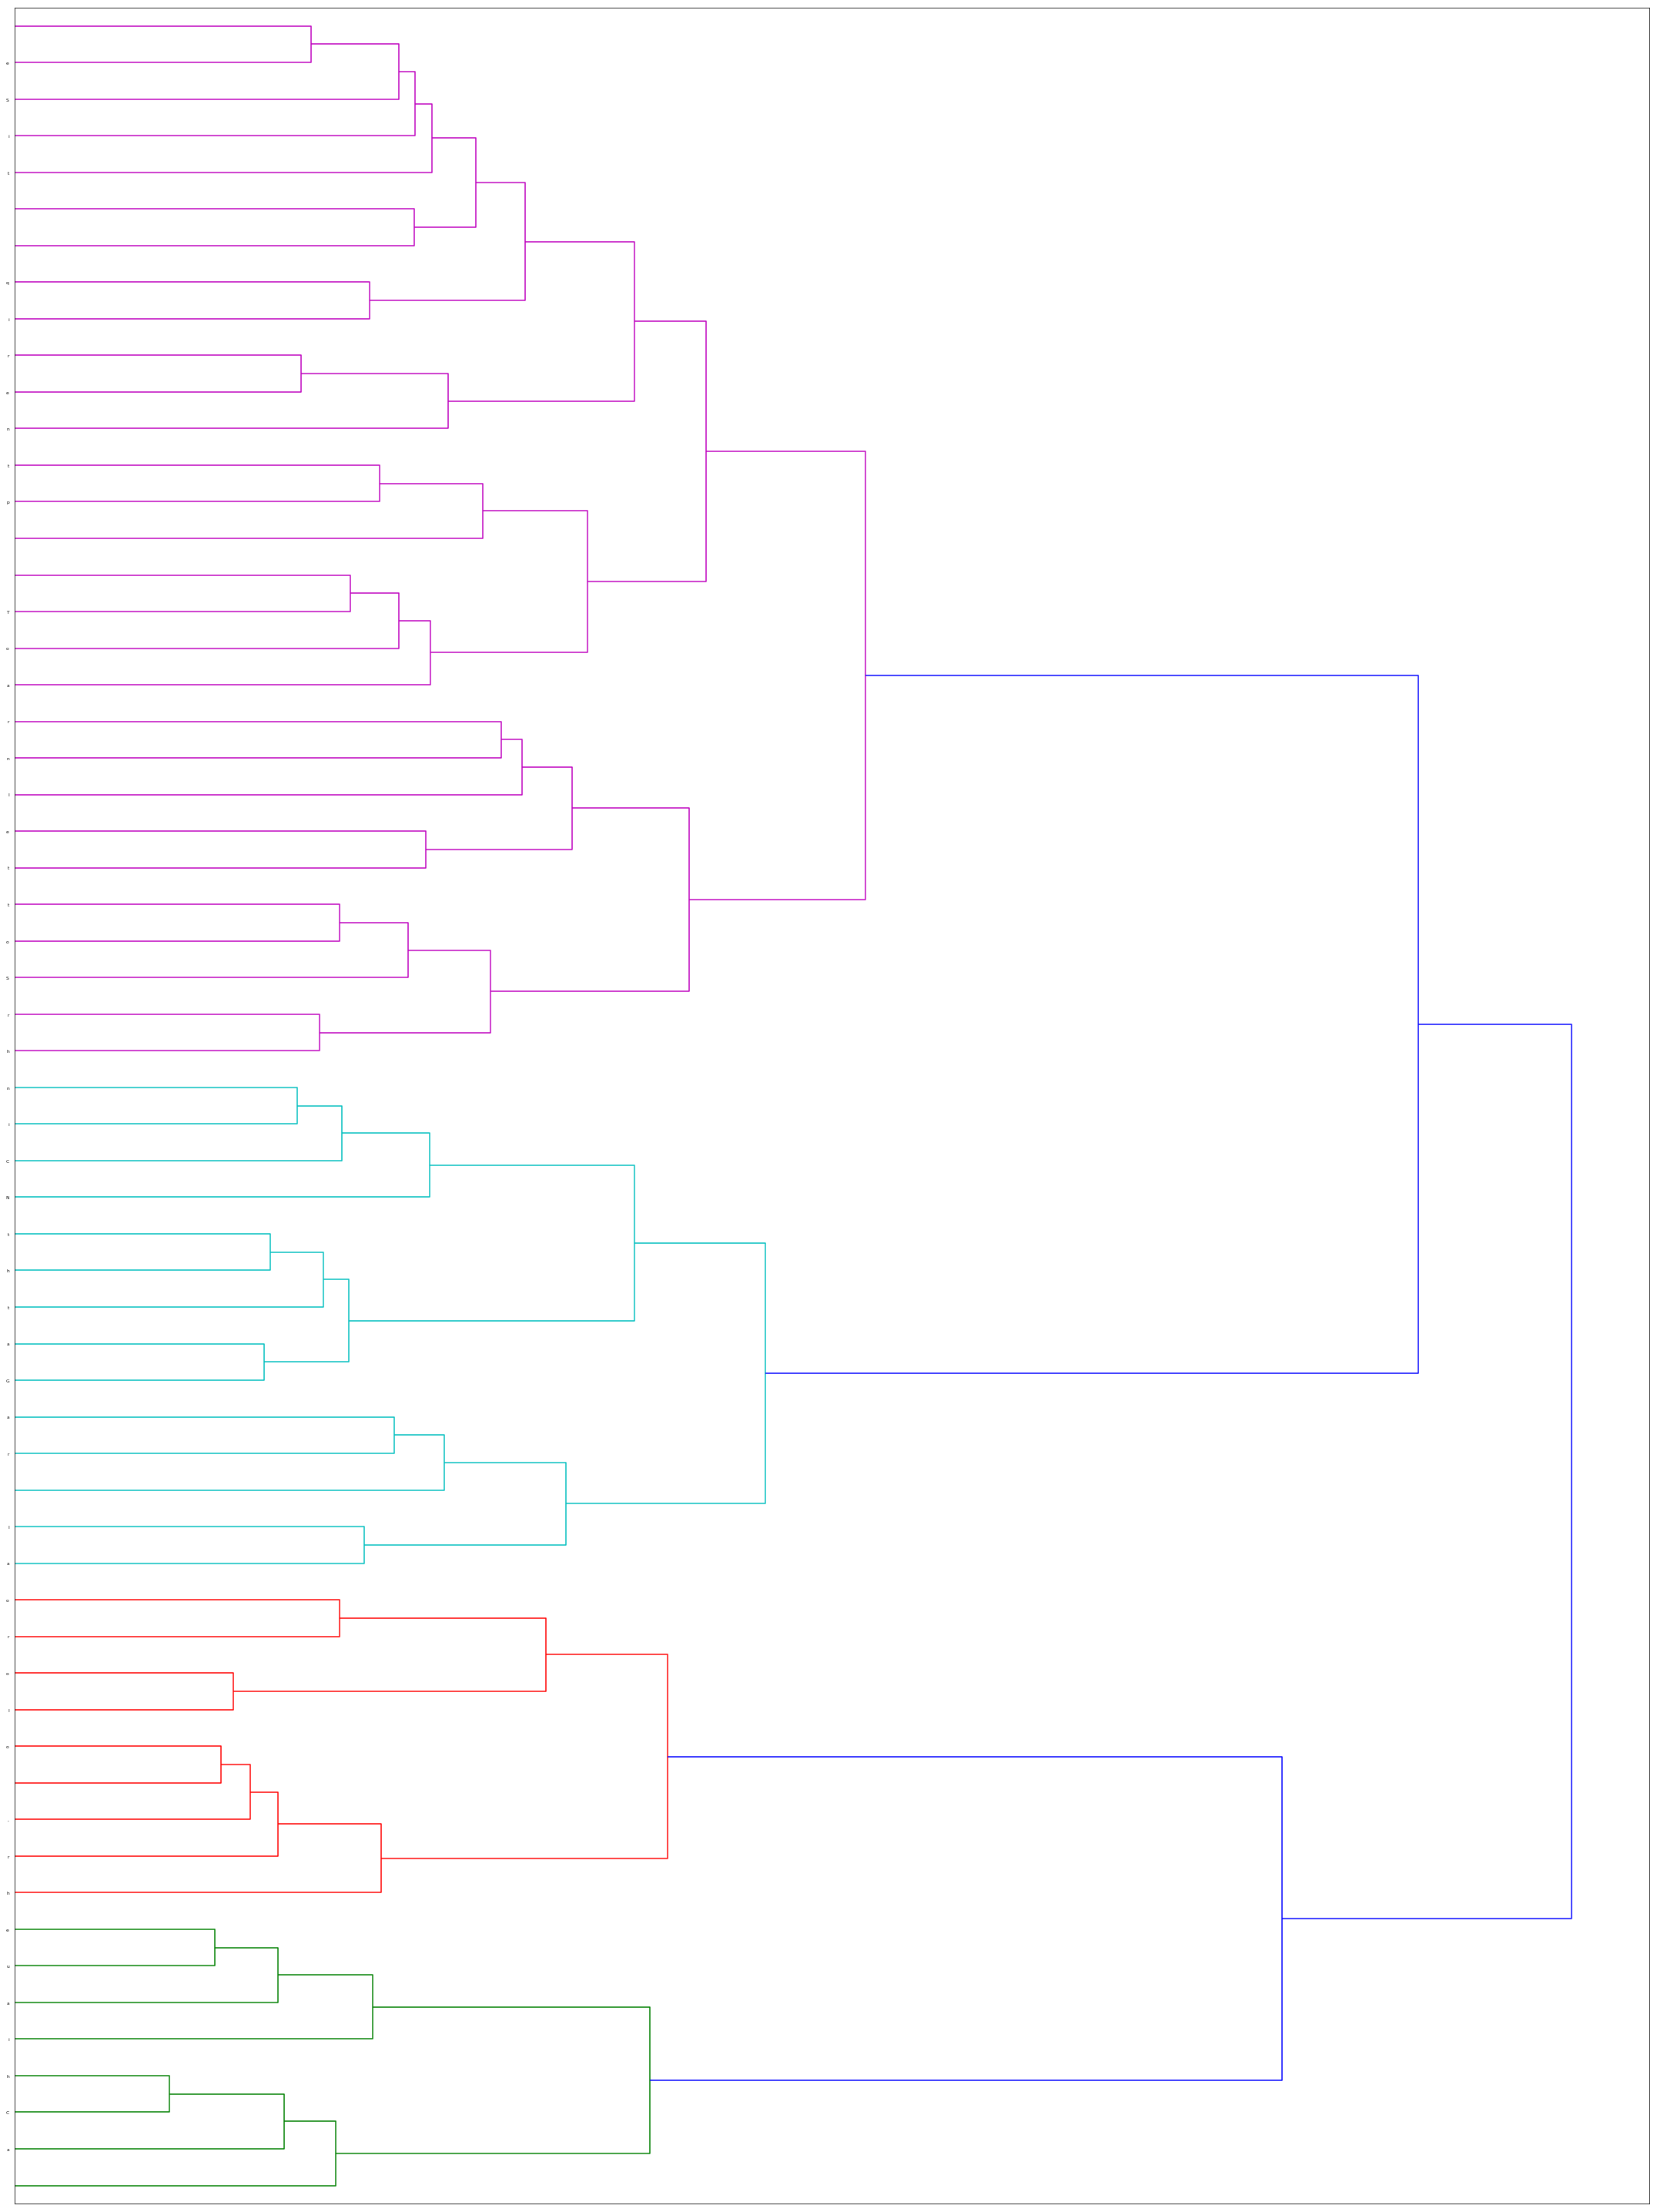

In [97]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(30, 40)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels = titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters